In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, losses, metrics


# Suppress TensorFlow warnings for clarity
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [23]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),  # Rotates images by a factor between -10% and +10%
    layers.RandomZoom(0.1),
])

In [25]:
labels_df = pd.read_csv('/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
labels_df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [26]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))


There is 17 unique labels including {'blooming', 'road', 'blow_down', 'habitation', 'primary', 'partly_cloudy', 'clear', 'haze', 'water', 'cultivation', 'agriculture', 'slash_burn', 'bare_ground', 'cloudy', 'artisinal_mine', 'selective_logging', 'conventional_mine'}


<Axes: xlabel='count', ylabel='None'>

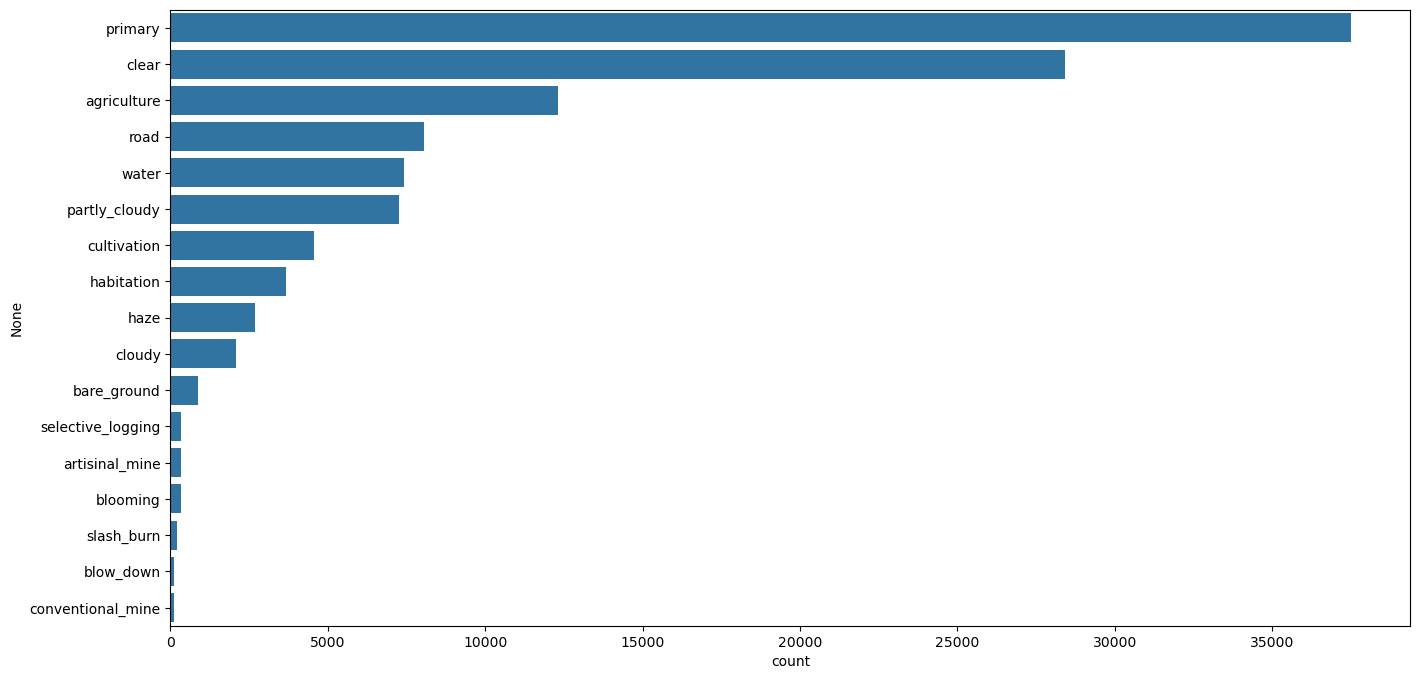

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')


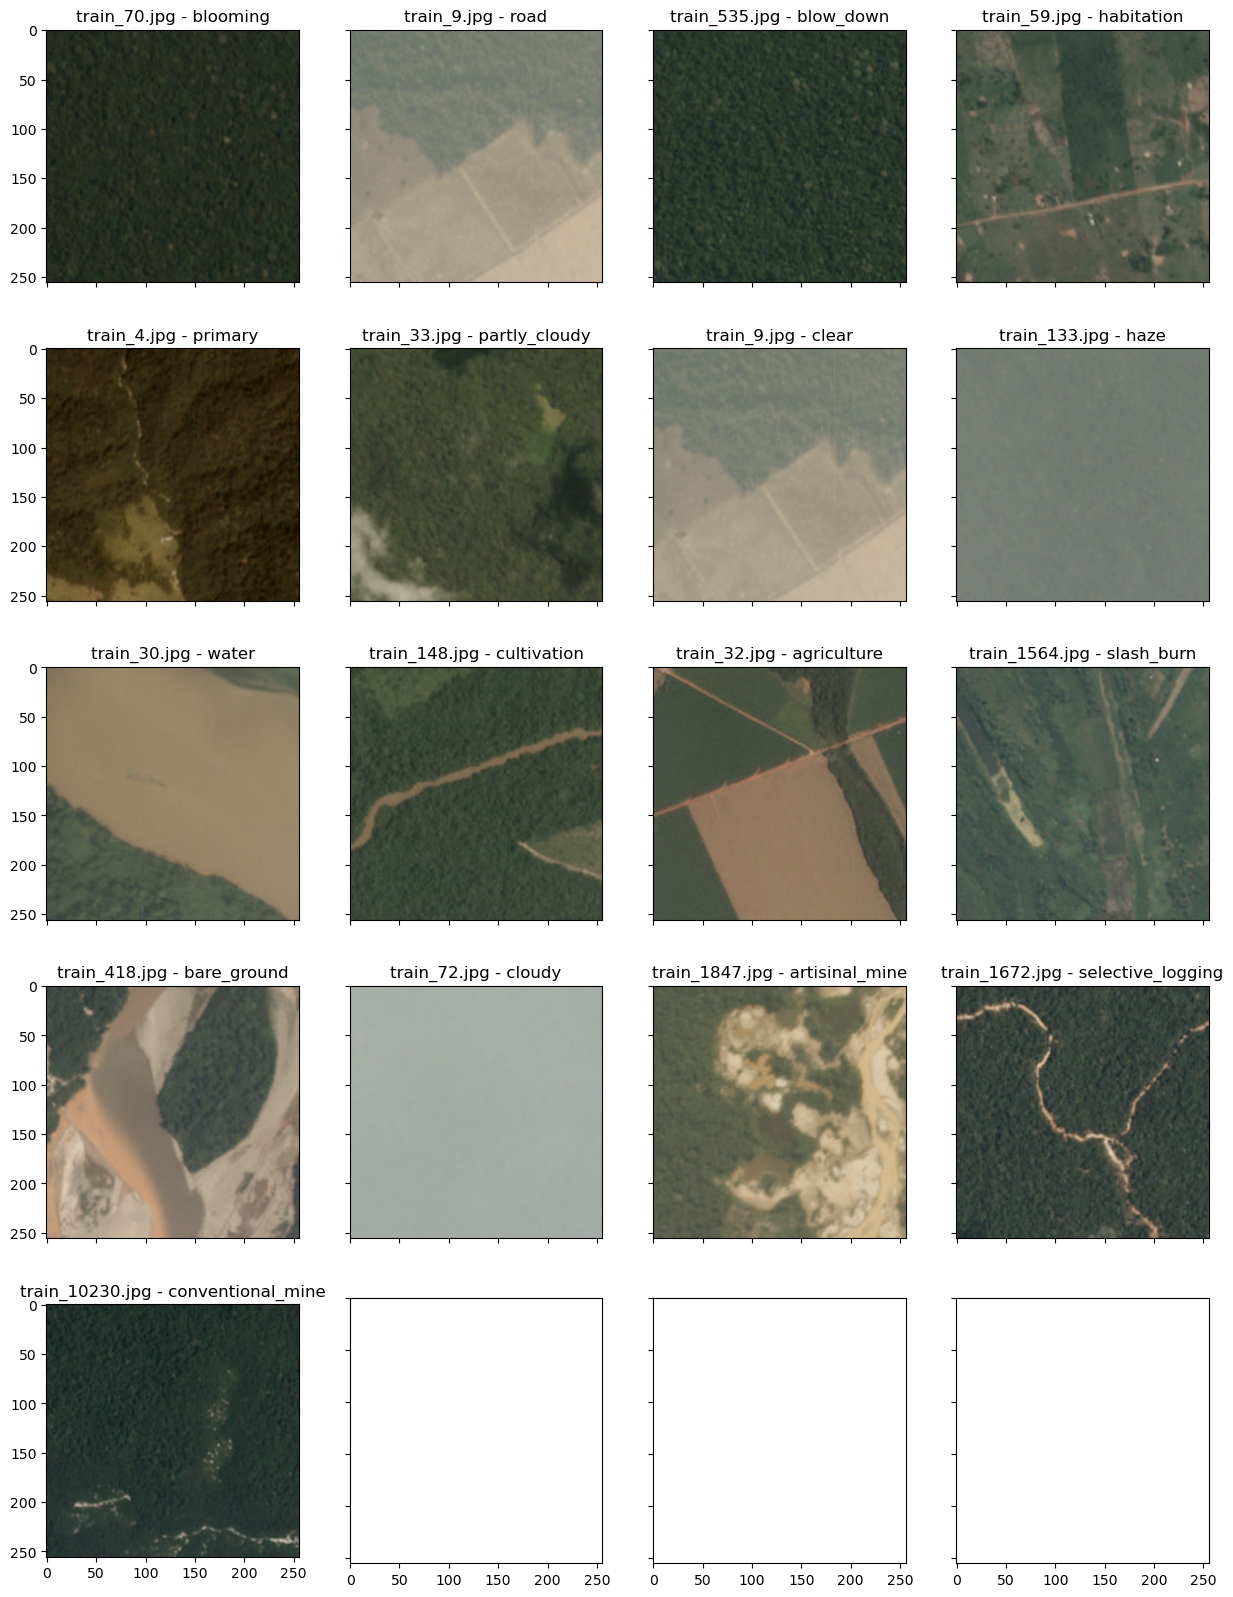

In [28]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread('/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))


In [29]:
# Input parameters
train_jpeg_dir = '/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/planet/planet/train-jpg'
train_csv_file = '/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
test_jpeg_dir = '/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/planet/planet/test-jpg'
test_additional_jpeg_dir = '/Users/walkerfryling/Desktop/Satellite-Image-Analysis-main/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'
img_resize = (128, 128)  # Desired image size
validation_split = 0.2
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [30]:
# Step 1: Read Labels and File Paths
labels_df = pd.read_csv(train_csv_file)

# Step 2: Extract all unique labels
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))

# Step 3: Create a mapping from label to index
labels_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels_map)

In [31]:
# Step 4: Map Labels to Integers and One-Hot Encode
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

In [32]:
# Step 5: Split Data into Training and Validation Sets
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [33]:
# Step 6: Define the Pure Python Image Loading Function
def _load_image(path_str):
    """
    Load and preprocess an image from a given file path.

    Args:
        path_str (bytes): The file path as a bytes object.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array.
    """
    try:
        from PIL import Image  # Import inside the function to ensure accessibility

        # Decode the bytes to a UTF-8 string
        path_str = path_str.decode('utf-8')

        # Open the image using PIL
        with Image.open(path_str) as img:
            # Convert image to RGB (handles CMYK and other modes)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(img_resize)
            # Convert to NumPy array and normalize to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0
            # Normalize to [-1, 1]
            img_array = (img_array * 2.0) - 1.0

        return img_array
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        # Return a zero tensor as a placeholder to prevent pipeline failure
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

In [34]:
# Step 7: Define the TensorFlow Wrapper Function using tf.numpy_function
def load_and_preprocess_image_numpy(path, label):
    """
    TensorFlow wrapper for loading and preprocessing an image using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.
        label (tf.Tensor): The corresponding label tensor.

    Returns:
        tuple: A tuple of the preprocessed image tensor and label tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image, label

In [35]:
def augment_image(image, label):
    """
    Apply data augmentation to the image.
    
    Args:
        image (tf.Tensor): The input image tensor.
        label (tf.Tensor): The corresponding label tensor.
    
    Returns:
        tuple: The augmented image tensor and the original label tensor.
    """
    image = data_augmentation(image)
    return image, label

In [36]:
# Step 8: Define the Dataset Creation Function using tf.numpy_function
def create_dataset_numpy(df, training=True):
    """
    Create a TensorFlow dataset from a DataFrame using tf.numpy_function.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        training (bool): Whether the dataset is for training (enables shuffling).

    Returns:
        tf.data.Dataset: The prepared dataset.
    """
    # Construct full file paths
    image_paths = df['image_name'].apply(lambda x: os.path.join(train_jpeg_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)

    # Create a TensorFlow Dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the load_and_preprocess_image_numpy function to the dataset
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)

    if training:
        # Shuffle the dataset for training
        dataset = dataset.shuffle(buffer_size=1000)
        # Apply data augmentation
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch the dataset for optimal performance
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

    return dataset


In [37]:
# Step 9: Create Training and Validation Datasets using tf.numpy_function
train_dataset_numpy = create_dataset_numpy(train_df, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, training=False)

In [38]:
# Step 10: Verify the Datasets
print("\nVerifying Training Dataset with tf.numpy_function:")
for images, labels in train_dataset_numpy.take(1):
    print("Image tensor shape:", images.shape)
    print("Image tensor dtype:", images.dtype)
    print("Image tensor min value:", tf.reduce_min(images).numpy())
    print("Image tensor max value:", tf.reduce_max(images).numpy())
    print("Image tensor mean value:", tf.reduce_mean(images).numpy())
    break



Verifying Training Dataset with tf.numpy_function:
Image tensor shape: (32, 128, 128, 3)
Image tensor dtype: <dtype: 'float32'>
Image tensor min value: -0.93890524
Image tensor max value: 0.47509044
Image tensor mean value: -0.39817128


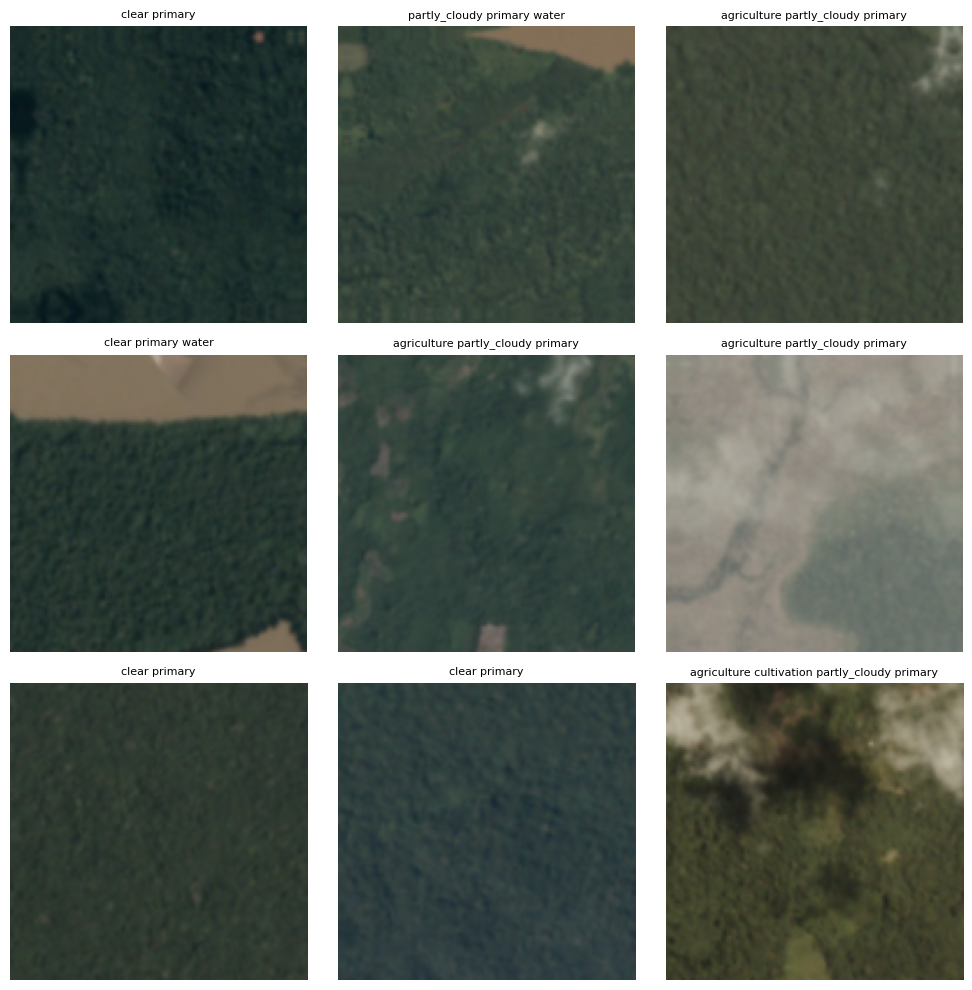

In [39]:
# Step 11: Plot a Batch of Images to Confirm
# Create a reverse mapping from index to label
index_to_label = {idx: label for label, idx in labels_map.items()}

def decode_label(one_hot_label):
    indices = np.where(one_hot_label == 1)[0]
    tags = [index_to_label[idx] for idx in indices]
    return " ".join(tags)

# Extract one batch of images and labels from the training dataset
for images, labels in train_dataset_numpy.take(1):
    images_np = images.numpy()
    labels_np = labels.numpy()
    break

# Convert images from [-1, 1] to [0, 1] for visualization
images_np = (images_np + 1.0) / 2.0

# Plot the images with labels
num_images_to_display = 9
plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_np[i])
    plt.axis("off")
    # Decode the label
    label = decode_label(labels_np[i])
    ax.set_title(label, fontsize=8)
plt.tight_layout()
plt.show()

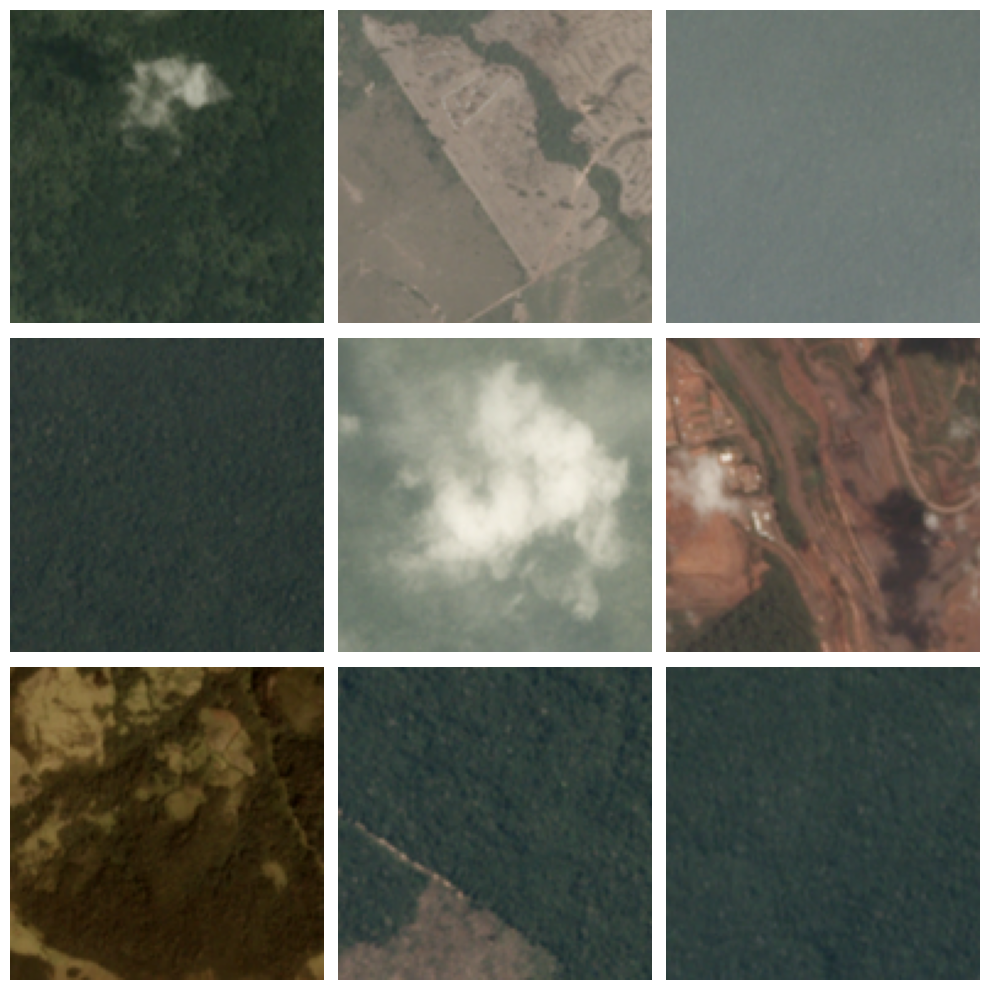

In [40]:
# Step 12: Create Test Dataset using tf.numpy_function and PIL-based Loader
def load_and_preprocess_test_image_numpy(path):
    """
    TensorFlow wrapper for loading and preprocessing test images using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image

# Get test file paths
test_files = [os.path.join(test_jpeg_dir, f) for f in os.listdir(test_jpeg_dir)]
test_files += [os.path.join(test_additional_jpeg_dir, f) for f in os.listdir(test_additional_jpeg_dir)]

# Create test dataset using the PIL-based loader
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_test_image_numpy, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

# (Optional) Visualize Test Images Without Labels
num_test_images_to_display = 9
plt.figure(figsize=(10, 10))

for images in test_dataset.take(1):
    test_images_np = images.numpy()
    # Convert images from [-1, 1] to [0, 1] for visualization
    test_images_np = (test_images_np + 1.0) / 2.0
    break

for i in range(num_test_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images_np[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [41]:
# Step 11: Build the Model
model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 12: Train the Model
tf.get_logger().setLevel('DEBUG')
batch_size = 1  
train_dataset_small = train_dataset_numpy.batch(batch_size).take(10)  # Use only 10 samples for testing
val_dataset_small = val_dataset_numpy.batch(batch_size).take(5)  # Use only 5 samples for validation

def check_for_nans(dataset):
    for data, labels in dataset:
        if tf.reduce_any(tf.math.is_nan(data)):
            print("NaNs found in data")
            return True
        if tf.reduce_any(tf.math.is_nan(labels)):
            print("NaNs found in labels")
            return True
    print("No NaNs found in dataset")
    return False

# Check for NaNs in train and validation datasets
check_for_nans(train_dataset_numpy)
check_for_nans(val_dataset_numpy)

history = model.fit(train_dataset_numpy, validation_data=val_dataset_numpy, epochs=15)
%debug

2024-10-31 13:57:13.561030: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


No NaNs found in dataset
No NaNs found in dataset
Epoch 1/15


2024-10-31 13:57:17.337677: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Step 13: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_dataset_numpy)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

In [ ]:
# Optional: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()